# Natively handling Python collections
A key benefit of `mandala` over straightforward memoization is that it can make
Python collections (lists, dicts, ...) a native & transparent part of the
memoization process:

- `@op`s can return collections where each item is a separate `Ref`, so that
later `@op` calls can work with individual elements;
- `@op`s can also accept as input collections where each item is a separate
`Ref`, to e.g. implement aggregation operations over them.
- collections can reuse the storage of their items: if two collections share
some elements, each shared element is stored only once in storage.
- the relationship between a collection and each of its items is a native part
of the computational graph of `@op` calls, and can be propagated automatically
by `ComputationFrame`s. Indeed, **collections are implemented as `@op`s
internally**.

## Input/output collections must be explicitly annotated
By default, any collection passed as `@op` input or output will be stored as a
single `Ref` with no structure; the object is **opaque** to the `Storage`
instance. To make the collection **transparent** to the `Storage`, you must
override this behavior explicitly by using a custom type annotation, such as
`MList` for lists, `MDict` for dicts, ...:

In [1]:
from mandala.imports import Storage, op, MList

storage = Storage()

@op
def average(nums: MList[float]) -> float:
    return sum(nums) / len(nums)

with storage:
    a = average([1, 2, 3, 4, 5])

We can understand how the list was made transparent to the storage by inspecting
the computation frame:

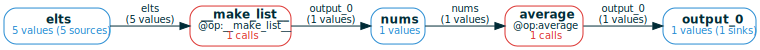

In [2]:
cf = storage.cf(average).expand_all(); cf.draw(verbose=True, orientation='LR')

We see that the internal `__make_list__` operation was automatically applied to
create a list, which is then the `Ref` passed to `average`. 

## How collections interact with `ComputationFrame`s
In general, CFs are turned into dataframes that capture the joint history of the
final `Ref`s in the CF. When there are collection `@op`s in the CF, a single
`Ref` (such as the element of `nums` above) can depend on multiple `Ref`s in
another variable (such as the `Ref`s in the `elts` variable).

We can observe this by taking the dataframe of the above CF:

In [3]:
print(cf.df(values='objs').to_markdown())

Extracting tuples from the computation graph:
    nums@output_0 = __make_list__(elts=elts)
    output_0@output_0 = average(nums=nums)
|    | elts                             | __make_list__                                   | nums            | average                                   |   output_0 |
|---:|:---------------------------------|:------------------------------------------------|:----------------|:------------------------------------------|-----------:|
|  0 | ValueCollection([2, 4, 1, 3, 5]) | Call(__make_list__, cid='3f6...', hid='172...') | [1, 2, 3, 4, 5] | Call(average, cid='445...', hid='f5b...') |          3 |


There's only a single row, but in the `elts` column we see a `ValueCollection`
object, indicating that there are multiple `Ref`s in `elts` that are
dependencies of `output_0`.